In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [34]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (np.cos(np.linspace(-np.pi, 0, n)))

In [35]:
def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

In [36]:
def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = np.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = np.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = np.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

9.162233390536123e-06


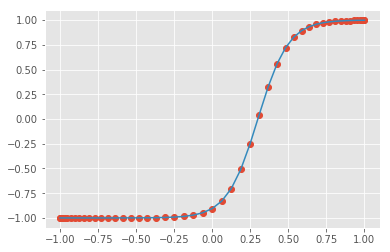

In [146]:
def laplacian_cheb(n, rhsfunc, left, right, a=1, b=1):
    """Solve the Laplacian boundary value problem on (-1,1) using n elements with rhsfunc(x) forcing.
    The left and right boundary conditions are specified as a pair (deriv, func) where
      * deriv=0 for Dirichlet u(x_endpoint) = func(x_endpoint)
      * deriv=1 for Neumann u'(x_endpoint) = func(x_endpoint)"""
    x = cosspace(-1, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    L = T[2] + a*T[1] + b*T[0]
    rhs = rhsfunc(x)
    for i,deriv,func in [(0, *left), (-1, *right)]:
        L[i] = T[deriv][i]
        rhs[i] = func(x[i])
    return x, L.dot(np.linalg.inv(T[0])), rhs

class exact_tanh:
    def __init__(self, k=1, x0=0):
        self.k = k
        self.x0 = x0
    def u(self, x):
        return np.tanh(self.k*(x - self.x0))
    def du(self, x):
        return self.k * np.cosh(self.k*(x - self.x0))**(-2)
    def ddu(self, x):
        return -2 * self.k**2 * np.tanh(self.k*(x - self.x0)) * np.cosh(self.k*(x - self.x0))**(-2)
s = 50
ex = exact_tanh(5, 0.3)
a = 3
b = 2.8
x, L, rhs = laplacian_cheb(s, lambda x: ex.ddu(x) + a*ex.du(x) + b*ex.u(x),
                           left=(0,ex.u), right=(1,ex.du), a = a, b = b 
                          )
uu = np.linalg.solve(L, rhs)
plt.plot(x, uu, 'o')
#plots the exact tanh function
plt.plot(x, ex.u(x))
print(np.linalg.norm(np.linalg.solve(L, rhs) - ex.u(x), np.inf))

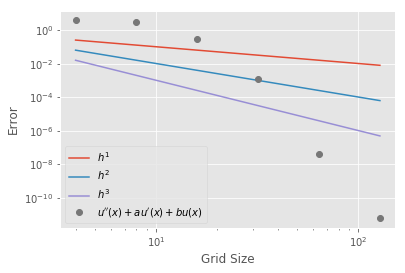

In [147]:
grids = 2**np.arange(2,8)
a = 2.1
b = 7
error = np.zeros(len(grids))
for i,g in enumerate(grids):
    x, L, rhs = laplacian_cheb(g, lambda x: ex.ddu(x) + a*ex.du(x) + b*ex.u(x),
                              left=(0,ex.u), right=(1,ex.du), a=a, b=b
                              )
    uu = np.linalg.solve(L, rhs)
    error[i] = np.linalg.norm(uu - ex.u(x), np.inf)
plt.xlabel('Grid Size')
plt.ylabel('Error')
for k in (1,2,3):
    plt.loglog(grids, 1/(grids**k), label='$h^{%d}$' % k)
plt.plot(grids, error,'o' ,label='$u\'\'(x) + au\'(x) + bu(x)$')
plt.legend(loc='lower left')
plt.show()

Here I kept the values for a & b set and we can see spectral convergence on the grid sizes. As the grid increases, the error decreases faster than any polynomial time $O(h^n)$

If the equation is of the form $ u''(t) + au'(t) + bu(t) = 0 $ use the test solution $ u(t) = e^{rt} $ and the roots end up being: 

$$ \frac{-1}{2} \pm \frac{\sqrt{a^2 - 4b}}{2} $$ 
$$$$

We can test two different modes by setting $ a^2 > 4b $ or $ a^2 < 4b $

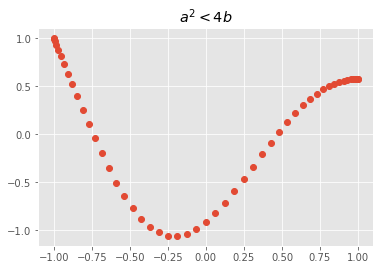

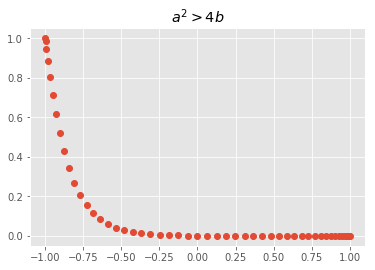

In [163]:
a = 1
b = 7
x, L, rhs = laplacian_cheb(s, lambda x: 0*x,
                           left=(0,lambda x: 1+0*x), right=(1,lambda x: 0*x), a = a, b = b 
                          )
uu = np.linalg.solve(L, rhs)
plt.title('$ a^2 < 4b $')
plt.plot(x, uu, 'o')
plt.show()
x, L, rhs = laplacian_cheb(s, lambda x: 0*x,
                           left=(0,lambda x: 1+0*x), right=(1,lambda x: 0*x), a = b, b = a 
                          )
uu = np.linalg.solve(L, rhs)
plt.title('$ a^2 > 4b $')
plt.plot(x, uu, 'o')
plt.show()